In [2]:
import pandas as pd
import numpy as np
import nltk
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_pickle('../data/out/data.pkl')
df

,name,date,revenue,runtime,languages,countries,genres,summary,phrases
0,Blacksmith Scene,1893-01-01,NaN,0.566667,[Silent film],[United States of America],"[Black-and-white, Indie, Short, Silent]",The scene is all filmed from a stationary came...,"[anvil, beer, blacksmith, camera, metal]"
1,Miss Jerry,1894-10-09,NaN,NaN,[Silent film],[United States of America],"[Black-and-white, Indie, Short, Silent]",After finding out that her father is suffering...,"[editor, financial problems, hamilton, heart, ..."
2,Corbett and Courtney Before the Kinetograph,1894-11-17,NaN,NaN,[Silent film],[United States of America],"[Black-and-white, Indie, Short, Silent]",James J. Corbett and Peter Courtney both take ...,"[boxing, hero]"
3,La Mer,1895-01-01,NaN,0.633333,[Silent film],[France],"[Black-and-white, Documentary, Indie, Short, S...",This 38 second film has a very simple plot in ...,"[film, jetty, water]"
4,Autour d'une cabine,1895-01-01,NaN,15.000000,[Silent film],[France],"[Animation, Comedy, Indie, Short, Silent]",The film consists of a series of animations on...,"[beach, boat, diving, dog, film, play, swimmin..."
...,...,...,...,...,...,...,...,...,...
42193,Kisaragi,NaT,NaN,108.000000,[],[],"[Comedy, Mystery]",One year after the suicide of C-list model Kis...,"[death, model, suicide, talk]"
42194,Mother Fish,NaT,NaN,92.000000,[Vietnamese],[],[Drama],Mother Fish follows the story of a middle-aged...,"[boat, death, engine, fish, food, imdb, led, m..."
42195,Deewana Tere Naam Ka,NaT,NaN,140.000000,[Hindi],[],[Drama],"Deewana Tere Naam Ka is a family drama, featur...","[danny denzongpa, drama, family, jagdeep, lead..."
42196,Hunter Prey,NaT,NaN,90.000000,[],[],[Science Fiction],A group of elite interstellar commandos crash ...,"[ai, bit, bounty hunter, breaks loose, command..."


### Genres column exploration

In [4]:
genres = df['genres'].dropna()

In [5]:
# total number of genres
genres.explode().nunique()

343

<AxesSubplot:>

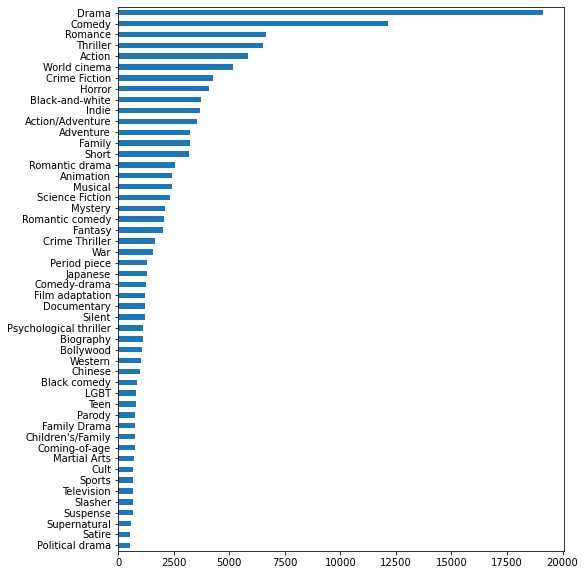

In [6]:
#distribution of top 50 common genres
dist = genres.explode().value_counts(ascending = True)
dist[-50:].plot(kind = 'barh',figsize = (8,10))

In [7]:
df = df.dropna(subset = ['genres'])

### Baseline model

In [8]:
def summary_preprocessing(plot):
    
    #remove punctuation
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    no_punct = plot.apply(lambda x: tokenizer.tokenize(x))
    
    #remove stopwords
    nltk.download('stopwords')
    stop_words = set(nltk.corpus.stopwords.words('english'))
    no_stopwords = no_punct.apply(lambda x: ' '.join([w for w in x if w not in stop_words]))
    
    return no_stopwords

In [14]:
def model(summary,genres):
    #tf-idf vectorizer
    multilabel_binarizer = sklearn.preprocessing.MultiLabelBinarizer()
    multilabel_binarizer.fit(genres)
    label = multilabel_binarizer.transform(genres)
    xtrain, xval, ytrain, yval = train_test_split(summary, label, test_size=0.2, random_state=9)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
    xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
    xval_tfidf = tfidf_vectorizer.transform(xval)
    
    #OneVsRest classifier
    lr = sklearn.linear_model.LogisticRegression()
    clf = OneVsRestClassifier(lr,n_jobs = 8)
#     scores = cross_validate(clf, xtrain_tfidf, ytrain, scoring=scoring)
    clf.fit(xtrain_tfidf,ytrain)
    y_pred = clf.predict(xval_tfidf)
    
    
    #evaluation
    f1 = sklearn.metrics.f1_score(yval, y_pred, average="micro")
    return f1, multilabel_binarizer.inverse_transform(yval), multilabel_binarizer.inverse_transform(y_pred),clf

In [15]:
df['processed_summary'] = summary_preprocessing(df['summary'])
f1_summary, genre_summary, predict_genre_summary,ests = model(df['processed_summary'],df['genres'])

[nltk_data] Downloading package stopwords to /home/humiao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
phrases_joined = df['phrases'].apply(lambda x: ' '.join(x))
f1_phrase,genre_phrase, predict_genre_phrase = model(phrases_joined,df['genres'])

In [11]:
#f1_score_summary,f1_score_phrase
f1_summary

0.32884236708467196

In [12]:
predict_genre_summary

[('Comedy', 'Drama'),
 (),
 (),
 ('Horror',),
 (),
 ('Horror', 'Slasher'),
 ('Comedy',),
 ('Comedy',),
 ('Comedy',),
 ('Horror',),
 ('Drama', 'Romance'),
 ('Drama',),
 ('Comedy',),
 ('Action', 'Horror'),
 ('Drama', 'Romance'),
 ('Comedy',),
 (),
 ('Comedy', 'Drama', 'Romance'),
 ('Action', 'Adventure'),
 (),
 (),
 ('Drama',),
 ('Mystery', 'Thriller'),
 ('Black-and-white', 'Comedy', 'Romance'),
 (),
 ('Comedy',),
 ('Drama',),
 ('Drama', 'Romance'),
 ('Drama',),
 (),
 (),
 ('Action', 'Crime Fiction', 'Crime Thriller', 'Drama', 'Mystery', 'Thriller'),
 (),
 (),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 (),
 ('Drama',),
 ('Horror',),
 ('Drama',),
 ('Action/Adventure',),
 ('Documentary',),
 (),
 ('Thriller',),
 ('Action', 'Action/Adventure', 'Western'),
 ('Adventure', 'Thriller'),
 (),
 ('Comedy',),
 ('Drama', 'Romance'),
 (),
 ('Comedy',),
 ('Drama',),
 (),
 (),
 (),
 ('Drama',),
 ('Drama',),
 ('Horror', 'Thriller'),
 ('Drama', 'Japanese', 'World cinema'),
 (),
 (),
 (),
 ('Comedy',),
 ('Dra

In [13]:
predict_genre_phrase

[('Drama',),
 (),
 (),
 (),
 ('Adventure', 'Fantasy'),
 ('Comedy',),
 ('Comedy',),
 (),
 (),
 ('Horror',),
 ('Drama',),
 ('Drama',),
 ('Comedy',),
 (),
 ('Drama',),
 (),
 ('Animation', 'Short'),
 ('Comedy', 'Drama', 'Romance'),
 ('Action', 'Action/Adventure'),
 (),
 (),
 ('Drama',),
 (),
 ('Romance',),
 (),
 (),
 (),
 ('Drama',),
 ('Drama',),
 (),
 ('Action', 'Science Fiction', 'Thriller'),
 ('Action', 'Crime Fiction', 'Crime Thriller', 'Drama', 'Thriller'),
 (),
 (),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 (),
 (),
 ('Horror',),
 (),
 ('Action/Adventure',),
 ('Documentary',),
 (),
 ('Crime Fiction', 'Drama', 'Thriller'),
 ('Action', 'Action/Adventure', 'Western'),
 (),
 ('Drama',),
 ('Comedy',),
 ('Drama',),
 ('Drama',),
 ('Comedy',),
 ('Drama',),
 ('Adventure',),
 ('Adventure', 'Comedy'),
 ('Comedy', 'Romance'),
 ('Drama',),
 ('Drama',),
 ('Horror', 'Thriller'),
 ('Drama', 'World cinema'),
 ('Comedy',),
 (),
 ('Drama',),
 ('Comedy', 'Drama'),
 (),
 (),
 ('Drama',),
 (),
 ('Action', '

### Evaluation metrics

#### percentage of labels that were predicted correctly

In [14]:
total_label = sum(genres.apply(len))
total_label

149300

In [15]:
print(np.sum([len(set(a).intersection(b)) for a, b in zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))]))
print(np.sum([len(set(a).intersection(b)) for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))]))
print(np.sum([len(set(a).intersection(b))>0 for a, b in zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))]))
print(np.sum([len(set(a).intersection(b))>0 for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))]))

5932
6346
4506
4822


In [16]:
np.sum([len(set(a).intersection(b)) for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))])

6346

In [17]:
np.sum([len(set(a).intersection(b))>0 for a, b in zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))])

4506

In [18]:
np.sum([len(set(a).intersection(b))>0 for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))])

4822

In [19]:
summary_left_out = pd.Series(list(set(b).intersection(a)) for a, b in zip(pd.Series(predict_genre_summary), \
                                                                pd.Series(genre_summary))).explode().value_counts()
phrase_left_out = pd.Series(list(set(b).intersection(a)) for a, b in zip(pd.Series(predict_genre_phrase), \
                                                                pd.Series(genre_phrase))).explode().value_counts()

dstr = pd.Series(genre_summary).explode().value_counts()

In [20]:
left_out_pctg = (summary_left_out/dstr)
left_out_pctg_phrase = (phrase_left_out/dstr)
left_out_pctg.loc[~left_out_pctg.isnull()].rename('summary_pctg').to_frame().merge(left_out_pctg_phrase.rename('phrase_pctg'),how = 'left',left_index = True, right_index = True)\
.merge(dstr.rename('dstr'),how = 'left',left_index = True,right_index = True).sort_values(ascending = False,by = 'summary_pctg')

,summary_pctg,phrase_pctg,dstr
Drama,0.655065,0.639221,3850
Comedy,0.418807,0.333471,2414
Horror,0.412736,0.379717,848
Short,0.347896,0.330097,618
War,0.330097,0.297735,309
Animation,0.301031,0.278351,485
Science Fiction,0.276498,0.269585,434
Thriller,0.272209,0.246944,1227
Action,0.270175,0.250877,1140
Documentary,0.251938,0.131783,258


### Subset of genres

In [21]:
genre_subset = ['Drama','Comedy','Romance','Thriller','Action','Horror']
df['subset_genres'] = df['genres'].apply(lambda x: [i for i in x if i in genre_subset])
df['subset_genres'] = df['subset_genres'].apply(lambda x: np.nan if len(x)==0 else x)
subset_df = df.dropna(subset = ['subset_genres'])

In [22]:
subset_df['processed_summary'] = summary_preprocessing(subset_df['summary'])
# subset_labels = genre_to_label(subset_df['subset_genres'])
f1_summary_, genre_summary, predict_genre_summary = model(subset_df['processed_summary'],subset_df['subset_genres'])

[nltk_data] Downloading package stopwords to /home/humiao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
subset_phrases_joined = subset_df['phrases'].apply(lambda x: ' '.join(x))
f1_phrase_, genre_phrase, predict_genre_phrase = model(subset_phrases_joined,subset_df['subset_genres'])

In [24]:
print(np.sum([len(set(a).intersection(b)) for a, b in zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))]))
print(np.sum([len(set(a).intersection(b)) for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))]))
print(np.sum([len(set(a).intersection(b))>0 for a, b in zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))]))
print(np.sum([len(set(a).intersection(b))>0 for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))]))

5569
5932
4924
5220


### parameter tuning

In [16]:
def model_gs(summary,genres):
    #tf-idf vectorizer
    multilabel_binarizer = sklearn.preprocessing.MultiLabelBinarizer()
    multilabel_binarizer.fit(genres)
    label = multilabel_binarizer.transform(genres)
    xtrain, xval, ytrain, yval = train_test_split(summary, label, test_size=0.2, random_state=9)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
    xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
    xval_tfidf = tfidf_vectorizer.transform(xval)
    
    #OneVsRest classifier
    

    parameters = {
        "estimator__penalty": ['l1'],
#         "estimator__solver":['newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
        "estimator__solver":[ 'liblinear', 'lbfgs'],
        "estimator__C":[1,3],
    }
    lr = sklearn.linear_model.LogisticRegression()
    clf = OneVsRestClassifier(lr,n_jobs = 8)
    model_tunning = GridSearchCV(clf, param_grid=parameters,cv = 3, verbose = 3, scoring = 'f1_micro',refit = True)
#     scores = cross_validate(clf, xtrain_tfidf, ytrain, scoring=scoring)
    model_tunning.fit(xtrain_tfidf,ytrain)
    y_pred = model_tunning.predict(xval_tfidf)
    tunning_f1 = f1_score(y_pred,yval, average = 'micro')

    
    
    #evaluation
#     f1 = sklearn.metrics.f1_score(yval, y_pred, average="micro")
    return model_tunning.best_score_,model_tunning.best_params_, model_tunning.best_estimator_,tunning_f1

In [17]:
score,param,est,f1= model_gs(df['processed_summary'],df['genres'])

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=  14.6s
[CV 2/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=  14.3s
[CV 3/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=  14.2s
[CV 1/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs; total time=   0.8s
[CV 2/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs; total time=   1.6s
[CV 3/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs; total time=   1.7s
[CV 1/3] END estimator__C=3, estimator__penalty=l1, estimator__solver=liblinear; total time=  22.3s
[CV 2/3] END estimator__C=3, estimator__penalty=l1, estimator__solver=liblinear; total time=  20.6s
[CV 3/3] END estimator__C=3, estimator__penalty=l1, estimator__solver=liblinear; total time=  20.8s
[CV 1/3] END estimator__C=3, estimator__penalty=l1, 

In [27]:
score,f1

(0.378365435775285, 0.40212422694272654)

### Visualization

In [18]:
multilabel_binarizer = sklearn.preprocessing.MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres'])
label = multilabel_binarizer.transform(df['genres'])
xtrain, xval, ytrain, yval = train_test_split(df['summary'], label, test_size=0.2, random_state=9)
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

<BarContainer object of 99 artists>

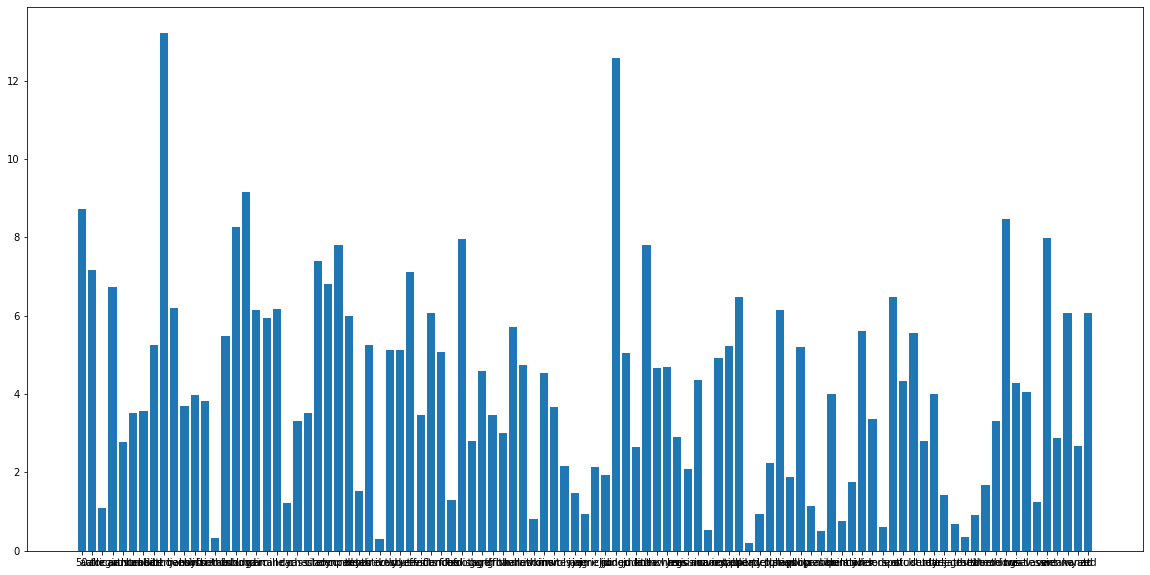

In [19]:
genre_label = multilabel_binarizer.classes_
contributed_words = tfidf_vectorizer.inverse_transform(est.estimators_[0].coef_)[0]
evd = [t for t in est.estimators_[0].coef_[0] if t >0]
plt.figure(figsize = (20,10))
plt.bar(x = contributed_words,height = evd)

In [23]:
lst = []
new_genre_label = []
for a,b in zip(est.estimators_,genre_label):
    try:
        lst.append(a.coef_)
        new_genre_label.append(b)
    except:
        pass


In [25]:
genre_coef = dict(zip(new_genre_label,np.vstack(lst)))

In [59]:
def genre_plot(genre,nlargest = 10):
    c = genre_coef[genre]
    words = tfidf_vectorizer.inverse_transform(c)[0]
    evd = [t for t in c if t >0]
    d = dict(zip(words,evd))
    sorted_words = sorted(d.items(), key=lambda item: item[1])[-10:]
    x = [i[0] for i in sorted_words]
    y = [i[1] for i in sorted_words]
    plt.figure()
    plt.barh(x,y,title = genre)

AttributeError: 'Rectangle' object has no property 'title'

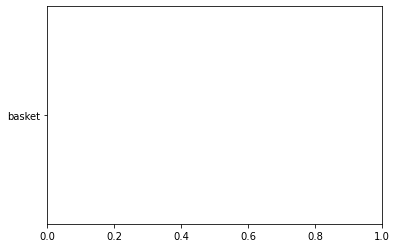

In [60]:
for g in dist[-10:].index:
    genre_plot(g)

In [53]:
dist

Political Documetary        1
Children's Issues           1
Silhouette animation        1
Breakdance                  1
C-Movie                     1
                        ...  
Action                   5867
Thriller                 6529
Romance                  6666
Comedy                  12138
Drama                   19130
Name: genres, Length: 343, dtype: int64

[('eleven', 9.20019665593629),
 ('levels', 9.723629194995626),
 ('introduction', 9.88810143309007),
 ('bianca', 10.00695035069798),
 ('contrary', 10.390475134975032),
 ('darla', 10.4206271365088),
 ('birthday', 11.123081562381119),
 ('attended', 11.88869936594574),
 ('easy', 12.116229999091772),
 ('denver', 12.469316134590859)]

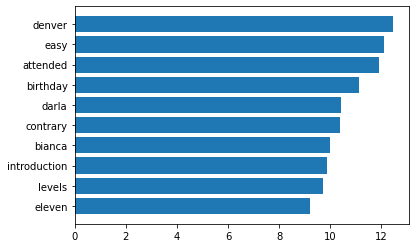

In [50]:
genre_plot('Comedy')

In [93]:
est.decision_function(xval_tfidf)

array([[-7.20100305, -9.46787192, -2.78857647, ..., -7.87914809,
        -9.98697859, -7.91300755],
       [-7.49530464, -9.46787192, -0.16463831, ..., -7.98775475,
        -9.98697859, -7.21453375],
       [-7.49530464, -9.46787192, -3.08914824, ..., -7.98775475,
        -9.98697859, -5.13239167],
       ...,
       [-7.49530464, -9.46787192, -1.3476828 , ..., -7.98775475,
        -9.98697859, -6.9921519 ],
       [-7.49530464, -9.46787192, -3.0417755 , ..., -7.98775475,
        -9.98697859, -7.21453375],
       [-7.01052286, -9.46787192, -2.49518507, ..., -7.92932023,
        -9.98697859, -6.87366116]])

In [55]:
len(tfidf_vectorizer.inverse_transform(est.estimators_[0].coef_)[0])

99

In [58]:
a =0
for i, n in enumerate(est.estimators_[0].coef_[0]):
    if n>0:
        print(str(i)+": "+str(n))
        a+=1

74: 8.729727308251316
180: 7.1601444131967575
258: 1.0914826599672263
355: 6.737441798062822
616: 2.7661085250342254
737: 3.5197707771012845
822: 3.5748593365717976
854: 5.250748046758285
919: 13.216779958389393
967: 6.196628321319988
970: 3.687165088468218
1072: 3.975518254012787
1164: 3.8351062881523275
1217: 0.32948131575384837
1234: 5.4812364447971325
1257: 8.267611317317236
1286: 9.16791904875208
1340: 6.142566813998801
1366: 5.9520981781063
1386: 6.160136994239711
1410: 1.2174671763997618
1465: 3.307412592237342
1617: 3.5062066990353693
1677: 7.411208909566989
1702: 6.803020491897655
1874: 7.799473656735947
2017: 5.991473152942315
2356: 1.5233156206242402
2525: 5.2591040602605394
2603: 0.2975001297770007
2772: 5.138488743389884
2851: 5.129549552890933
2870: 7.114157617281697
2931: 3.4575234008040816
3190: 6.082197466406798
3424: 5.078857627240875
3447: 1.2937737543896948
3570: 7.956019555444685
3572: 2.815528891464486
3767: 4.587520707434818
3974: 3.4645780855544484
3984: 3.01481

In [59]:
a 

99

In [37]:
score,param,est_phrase,f1_phrase = model_gs(df['phrases'].apply(lambda x: ' '.join(x)),df['genres'])

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=   5.6s
[CV 2/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=   5.5s
[CV 3/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=   5.6s
[CV 1/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs; total time=   0.7s
[CV 2/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs; total time=   1.9s
[CV 3/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs; total time=   2.0s
[CV 1/3] END estimator__C=3, estimator__penalty=l1, estimator__solver=liblinear; total time=   9.2s
[CV 2/3] END estimator__C=3, estimator__penalty=l1, estimator__solver=liblinear; total time=   7.8s
[CV 3/3] END estimator__C=3, estimator__penalty=l1, estimator__solver=liblinear; total time=   7.5s
[CV 1/3] END estimator__C=3, estimator__penalty=l1, 

In [38]:
score,f1_phrase

(0.3491524246261717, 0.369210247918679)

In [39]:
param

{'estimator__C': 3,
 'estimator__penalty': 'l1',
 'estimator__solver': 'liblinear'}

### pick sentence

In [42]:
import spacy
from tqdm import tqdm
from pandarallel import pandarallel
from sentence_transformers import SentenceTransformer



spacy_en = spacy.load("en_core_web_sm")


def pick_rep_sentences(row, n=5):
    """
    Pick sentences with highest average sublinear word tf-idfs
    as the representatives of the full text.
    """
    summary, phrases = row.summary, row.phrases

    spacy_doc = spacy_en(summary)
    sents = np.array([s.text for s in spacy_doc.sents])
    if len(sents) <= n:
        return sents
    if not phrases:
        return np.random.choice(sents, n, replace=False)

    cntv = CountVectorizer(vocabulary=phrases)
    tfidf = TfidfTransformer(sublinear_tf=True)
    ranks = (
        tfidf.fit_transform(cntv.fit_transform(sents)).toarray().sum(axis=1)
    )
    ranks /= np.array([len(s) for s in spacy_doc.sents])
    return sents[np.argpartition(-ranks, n)[:n]]


In [43]:
pandarallel.initialize(nb_workers=8)
rep_sents = df.parallel_apply(pick_rep_sentences, axis=1)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
score,param,est = model_gs(sents.apply(lambda x: ' '.join(x)),df['genres'])

In [48]:
sents = summary_preprocessing(rep_sents.apply(lambda x: ' '.join(x)))

[nltk_data] Downloading package stopwords to /home/humiao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
score_sents,param_sents,est_sents,f1_sents= model_gs(sents,df['genres'])

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=   7.8s
[CV 2/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=   6.6s
[CV 3/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=   6.6s
[CV 1/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs; total time=   0.7s
[CV 2/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs; total time=   1.7s
[CV 3/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs; total time=   1.8s
[CV 1/3] END estimator__C=3, estimator__penalty=l1, estimator__solver=liblinear; total time=  11.8s
[CV 2/3] END estimator__C=3, estimator__penalty=l1, estimator__solver=liblinear; total time=  10.2s
[CV 3/3] END estimator__C=3, estimator__penalty=l1, estimator__solver=liblinear; total time=   9.9s
[CV 1/3] END estimator__C=3, estimator__penalty=l1, 

In [51]:
score_sents,f1_sents

(0.3316630601335826, 0.34639319426640247)

In [76]:
def baseline_model(plot_summary,genre):

    """preprocessing, vectorization, and classifcation with OneVsRestClassifier and Logistic Regression"""
    #remove punctuation
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    no_punct = plot_summary.apply(lambda x: tokenizer.tokenize(x))
    
    #remove stopwords
    nltk.download('stopwords')
    stop_words = set(nltk.corpus.stopwords.words('english'))
    summary = no_punct.apply(lambda x: ' '.join([w for w in x if w not in stop_words]))
    
    #label binarizer
    multilabel_binarizer = sklearn.preprocessing.MultiLabelBinarizer()
    multilabel_binarizer.fit(genre)
    label = multilabel_binarizer.transform(genre)
   
    #split training and validation set
    xtrain, xval, ytrain, yval = train_test_split(summary, label, test_size=0.2, random_state=9)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
    xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
    xval_tfidf = tfidf_vectorizer.transform(xval)
    
    #OneVsRest classifier
    lr = sklearn.linear_model.LogisticRegression()
    clf = OneVsRestClassifier(lr,n_jobs = 8)
#     scores = cross_validate(clf, xtrain_tfidf, ytrain, scoring=scoring)
    clf.fit(xtrain_tfidf,ytrain)
    y_pred = clf.predict(xval_tfidf)
    
    
    #evaluation
    f1 = sklearn.metrics.f1_score(yval, y_pred, average="micro")
    
    e1 = 'percentage of genres that are correctly predicted: '+ str(np.sum([len(set(a).intersection(b)) for a, b in \
                  zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))])/sum(genre.apply(len)))
    e2 = 'percentage of movies that have at least one gnere predicted right: '+str(np.sum([len(set(a).intersection(b))>0 for a, b in\
                  zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))])/len(genre))
    return f1,e1,e2

In [77]:
baseline_model(df['summary'],df['genres'])

[nltk_data] Downloading package stopwords to /home/humiao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(0.32884236708467196,
 'percentage of genres that are correctly predicted: 0.037327528466175486',
 'percentage of movies that have at least one gnere predicted right: 0.11683018152519077')